In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import itertools
import statistics

In [15]:
from ipynb.fs.full.particle_file_search import search_particle_filter
from ipynb.fs.full.behavior_segmentation_search import search_behavior_segmentation
from ipynb.fs.full.plot_animals import plot_function

In [16]:
# import sys
# sys.path.append("file to folder")

In [17]:
#from readSessionsServer import SessionIterator

In [18]:
state_order = {
    'initRight': 0,
    'initLeft': 0,
    'mainRunLeft': 1,
    'turnMainToLeft': 2,
    'leftRun': 3,
    'leftReward': 4
}

In [19]:

# Code to read the h5 file that contains behavior segmentation
# pathname_2 = input("Insert path of behavior segmentation h5 file here: ")

# with pd.HDFStore(pathname_2) as hdf:
#     # This prints a list of all group names:
#     print("Reading the h5 file that contains the deeplabcut and calcium imaging data...")
#     print(hdf.keys())

# segmented = pd.read_hdf(pathname_2, key="/per_frame")

In [20]:
# Iterate through the particle filter directory and print the pathnames of files and place them in a list
particle_filter_list = search_particle_filter(dir_path = input("Insert directory path here: "))
print("Files in folder: \n", particle_filter_list)

Insert directory path here:  /Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_ParticleFilter


/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_ParticleFilter/20211016_170522_animal2learnday1_particlefilter.h5
/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_ParticleFilter/20211016_163921_animal1learnday1_particlefilter.h5
/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_ParticleFilter/20211016_173112_animal3learnday1_particlefilter.h5
Files in folder: 
 ['/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_ParticleFilter/20211016_163921_animal1learnday1_particlefilter.h5', '/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_ParticleFilter/20211016_170522_animal2learnday1_particlefilter.h5', '/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_ParticleFilter/20211016_173112_animal3learnday1_particlefilter.h5']

In [21]:
# Iterate behavioral segmentation directory
beh_segmentation_list = search_behavior_segmentation(dir_path = input("Insert directory path here: "))
print("Files in folder: \n", beh_segmentation_list)

Insert directory path here:  /Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_BehaviorSegmentation


/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_BehaviorSegmentation/20211016_173112_animal3learnday1_behavior_segmentation.h5
/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_BehaviorSegmentation/20211016_170522_animal2learnday1_behavior_segmentation.h5
/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_BehaviorSegmentation/20211016_163921_animal1learnday1_behavior_segmentation.h5
Files in folder: 
 ['/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_BehaviorSegmentation/20211016_163921_animal1learnday1_behavior_segmentation.h5', '/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_BehaviorSegmentation/20211016_170522_animal2learnday1_behavior_segmentation.h5', '/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1/AnimalsDay1_Be

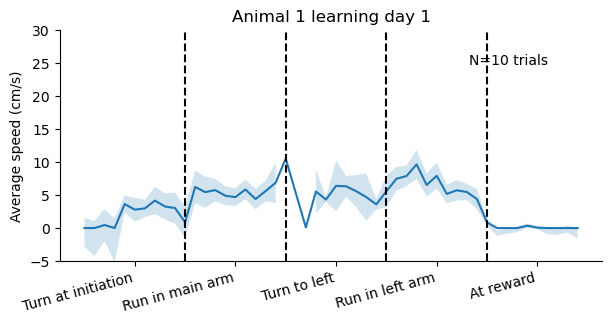

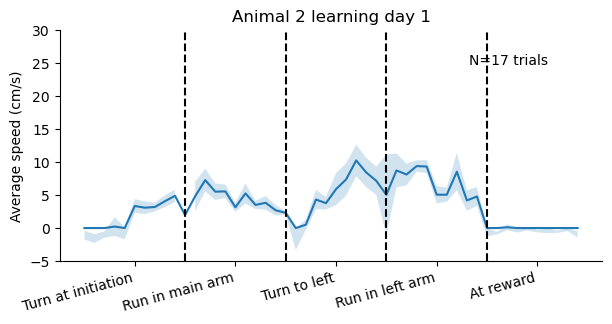

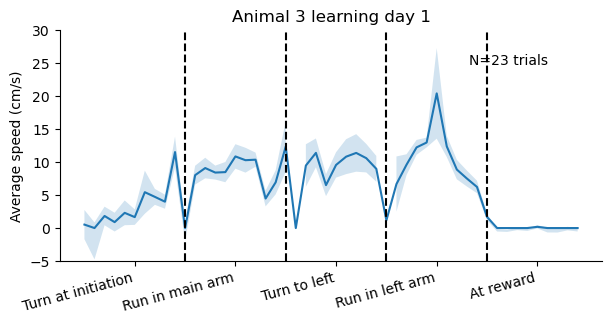

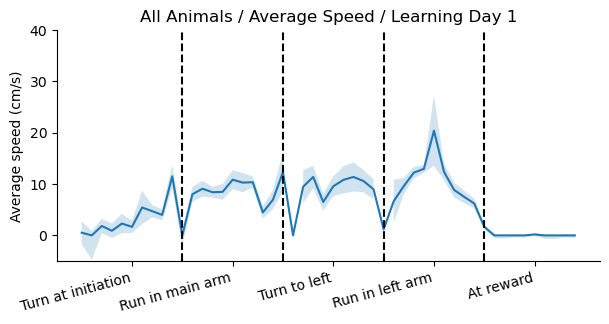

In [28]:
list_of_avg = []
x = 1

# Iterate through the particle filter and beh_segmentation lists that contain the absolute paths of the files of interest.
for (i, j) in zip(particle_filter_list, beh_segmentation_list):
    n_bins_per_seg = 10
    # for sess in SessionIterator("Miniscope recordings").findSessions():
    filtered = pd.read_hdf(i) # Particle Filter
    segmented = pd.read_hdf(j, key="/per_frame") # Behavioral Segmentation
    state_order_series = pd.Series(state_order, name="state_order")
    segmented_relevant = segmented.join(state_order_series, on="state_name")
    x_pos = segmented_relevant.spatial_progress + segmented_relevant.state_order
    speeds = filtered.speed[np.isfinite(x_pos)]
    bin_x = np.floor(x_pos[np.isfinite(x_pos)]*n_bins_per_seg).astype(int)
    gby = (60*speeds).groupby([bin_x, segmented_relevant.segment_no]).mean().groupby(level=0)
    avgs = gby.mean()
    low_q = gby.mean()-gby.sem()
    high_q = gby.mean()+gby.sem()
    N_trials = len(segmented[segmented.state_name == "leftReward"].segment_no.unique())
    avgs = avgs.clip(lower=0)
    list_of_avg += [avgs]

    # Plotting
    plt.figure(figsize=(7, 3))
    plt.plot(avgs)
    plt.fill_between(avgs.index, low_q, high_q, alpha=.2)
    plt.text(0.9, 0.85, f"N={N_trials} trials", ha="right", transform=plt.gca().transAxes)
    plt.title("Animal "+str(x)+" learning day 1")
    labels = ["Turn at initiation", "Run in main arm", "Turn to left", "Run in left arm", "At reward"]
    for i in range(1, 5):
        plt.axvline(i*n_bins_per_seg, color='k', linestyle='--')
    plt.xticks((np.arange(5)+0.5)*n_bins_per_seg, labels, rotation=15, ha="right")
    plt.ylabel("Average speed (cm/s)")
    plt.ylim(-5, 30)
    sns.despine()
    #print(i, j)
    x += 1

    # Saving plots
    plt.savefig('path'+'learningday'+str(x)+'.png', bbox_inches='tight', dpi=300 )
    plt.show()
    

# Average of all animals, learning day 1 with standard deviation

total_avg = pd.concat(list_of_avg, axis=1, ignore_index=True)
total_avg = total_avg[:-1]
total_avg = np.mean(total_avg, axis=1)


state_order_series = pd.Series(state_order, name="state_order")
segmented_relevant = segmented.join(state_order_series, on="state_name")
x_pos = segmented_relevant.spatial_progress + segmented_relevant.state_order
speeds = filtered.speed[np.isfinite(x_pos)]
bin_x = np.floor(x_pos[np.isfinite(x_pos)]*n_bins_per_seg).astype(int)
gby = (60*speeds).groupby([bin_x, segmented_relevant.segment_no]).mean().groupby(level=0)
total_avg = gby.mean() 
N_trials = len(segmented[segmented.state_name == "leftReward"].segment_no.unique())
plt.figure(figsize=(7, 3))
total_avg = total_avg.clip(lower=0)
plt.plot(total_avg)
plt.fill_between(total_avg.index, low_q, high_q, alpha=.2)


#plt.text(0.9, 0.85, f"N={N_trials} trials", ha="right", transform=plt.gca().transAxes)
plt.title("All Animals / Average Speed / Learning Day 1")
labels = ["Turn at initiation", "Run in main arm", "Turn to left", "Run in left arm", "At reward"]
for i in range(1, 5):
    plt.axvline(i*n_bins_per_seg, color='k', linestyle='--')
plt.xticks((np.arange(5)+0.5)*n_bins_per_seg, labels, rotation=15, ha="right")
plt.ylabel("Average speed (cm/s)")
plt.ylim(-5, 40)
sns.despine()
plt.show()


# Average of all animals learning day 11

In [23]:
# Iterate through the particle filter directory and print the pathnames of files and place them in a list
particle_filter_list_day11 = search_particle_filter(dir_path = input("Insert directory path here: "))
print("Files in folder: \n", particle_filter_list_day11)

Insert directory path here:  /Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_ParticleFilter


/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_ParticleFilter/20211028_181307_animal3learnday11_particlefilter.h5
/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_ParticleFilter/20211028_171719_animal1learnday11_particlefilter.h5
/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_ParticleFilter/20211028_174510_animal2learnday11_particlefilter.h5
Files in folder: 
 ['/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_ParticleFilter/20211028_171719_animal1learnday11_particlefilter.h5', '/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_ParticleFilter/20211028_174510_animal2learnday11_particlefilter.h5', '/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_ParticleFilter/20211028_181307_animal3learnday11_p

In [24]:
# Iterate behavioral segmentation directory
beh_segmentation_list_day11 = search_behavior_segmentation(dir_path = input("Insert directory path here: "))
print("Files in folder: \n", beh_segmentation_list_day11)

Insert directory path here:  /Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_BehaviorSegmentation


/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_BehaviorSegmentation/20211028_181307_animal3learnday11_behavior_segmentation.h5
/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_BehaviorSegmentation/20211028_174510_animal2learnday11_behavior_segmentation.h5
/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_BehaviorSegmentation/20211028_171719_animal1learnday11_behavior_segmentation.h5
Files in folder: 
 ['/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_BehaviorSegmentation/20211028_171719_animal1learnday11_behavior_segmentation.h5', '/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 11/AnimalsDay11_BehaviorSegmentation/20211028_174510_animal2learnday11_behavior_segmentation.h5', '/Users/pierre.le.merre/OneDrive - KI.SE/Mac/Desktop/KIlab/data-files/Learning Day 1

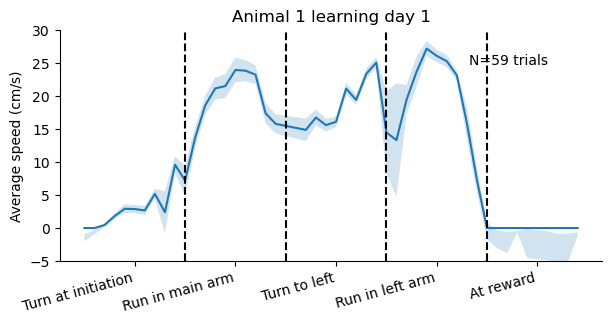

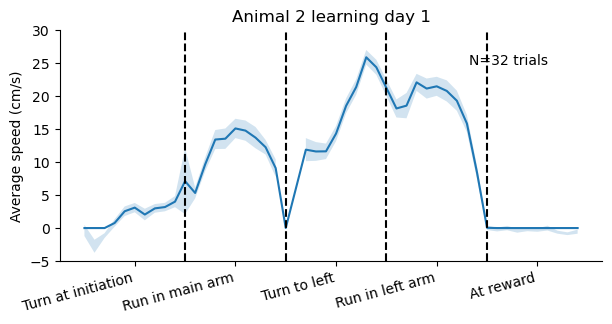

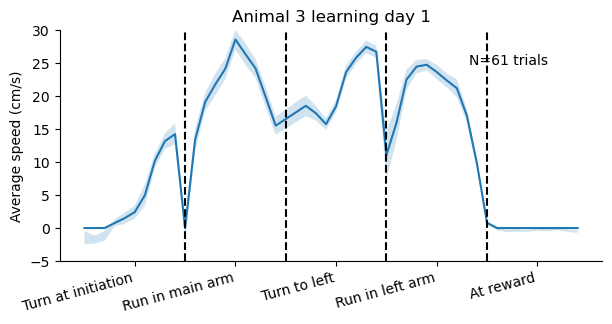

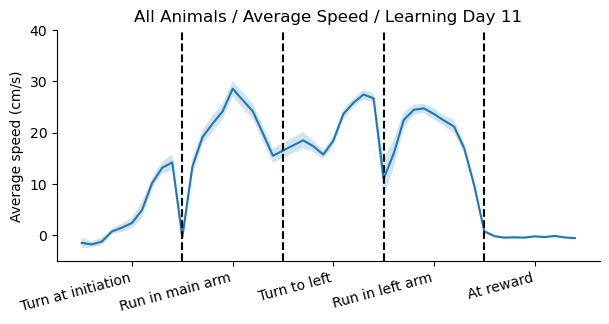

<Figure size 640x480 with 0 Axes>

In [29]:
list_of_avg_day11 = []
x = 1

# Iterate through the particle filter and beh_segmentation lists that contain the absolute paths of the files of interest.
for (i, j) in zip(particle_filter_list_day11, beh_segmentation_list_day11):
    n_bins_per_seg = 10
    # for sess in SessionIterator("Miniscope recordings").findSessions():
    filtered = pd.read_hdf(i) # Particle Filter
    # hf = h5py.File('data.h5', 'r')
    #segmented = h5py.File(j)
    segmented = pd.read_hdf(j, key="/per_frame") # Behavioral Segmentation
    state_order_series = pd.Series(state_order, name="state_order")
    segmented_relevant = segmented.join(state_order_series, on="state_name")
    x_pos = segmented_relevant.spatial_progress + segmented_relevant.state_order
    speeds = filtered.speed[np.isfinite(x_pos)]
    bin_x = np.floor(x_pos[np.isfinite(x_pos)]*n_bins_per_seg).astype(int)
    gby = (60*speeds).groupby([bin_x, segmented_relevant.segment_no]).mean().groupby(level=0)
    avgs_day11 = gby.mean()
    low_q = gby.mean()-gby.sem()
    high_q = gby.mean()+gby.sem()
    N_trials = len(segmented[segmented.state_name == "leftReward"].segment_no.unique())
    avgs_day11 = avgs_day11.clip(lower=0)
    list_of_avg_day11 += [avgs_day11]

    # Plotting
    plt.figure(figsize=(7, 3))
    plt.plot(avgs_day11)
    plt.fill_between(avgs_day11.index, low_q, high_q, alpha=.2)
    plt.text(0.9, 0.85, f"N={N_trials} trials", ha="right", transform=plt.gca().transAxes)
    plt.title("Animal "+str(x)+" learning day 1")
    labels = ["Turn at initiation", "Run in main arm", "Turn to left", "Run in left arm", "At reward"]
    for i in range(1, 5):
        plt.axvline(i*n_bins_per_seg, color='k', linestyle='--')
    plt.xticks((np.arange(5)+0.5)*n_bins_per_seg, labels, rotation=15, ha="right")
    plt.ylabel("Average speed (cm/s)")
    plt.ylim(-5, 30)
    sns.despine()
    #print(i, j)
    x += 1

    # # Saving plots
    # plt.savefig('path'+'learningday'+str(x)+'.png', bbox_inches='tight', dpi=300 )
    # plt.show()

    
# Average for all animals day 11

total_avg_day1 = pd.concat(list_of_avg_day11, axis=1, ignore_index=True)
total_avg_day1 = total_avg_day1[:-1]
total_avg_day1 = np.mean(total_avg_day1, axis=1)

# remove nan values
state_order_series = pd.Series(state_order, name="state_order")
segmented_relevant = segmented.join(state_order_series, on="state_name")
x_pos = segmented_relevant.spatial_progress + segmented_relevant.state_order
speeds = filtered.speed[np.isfinite(x_pos)]
bin_x = np.floor(x_pos[np.isfinite(x_pos)]*n_bins_per_seg).astype(int)
gby = (60*speeds).groupby([bin_x, segmented_relevant.segment_no]).mean().groupby(level=0)
total_avg_day1 = gby.mean()
N_trials = len(segmented[segmented.state_name == "leftReward"].segment_no.unique())
plt.figure(figsize=(7, 3))
total_avg = total_avg.clip(lower=0)


# Plotting
plt.title("All Animals / Average Speed / Learning Day 11")
plt.plot(total_avg_day1)
plt.fill_between(total_avg_day1.index, low_q, high_q, alpha=.2)

for i in range(1, 5):
    plt.axvline(i*n_bins_per_seg, color='k', linestyle='--')
plt.xticks((np.arange(5)+0.5)*n_bins_per_seg, labels, rotation=15, ha="right")
plt.ylabel("Average speed (cm/s)")
plt.ylim(-5, 40)
sns.despine()
plt.show()


# Saving plots
plt.savefig('path'+'learningday'+str(x)+'.png', bbox_inches='tight', dpi=300 )
plt.show()